In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle, glob, sys, os

from utils import *
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import mixture

from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.stats import multivariate_normal, beta, gamma, norm, skewnorm, skew, kurtosis, t


# Save model in path with name
def save_model(C_, path, name):
    with open(path.format(name), 'wb') as f:
        pickle.dump(C_, f)

ImportError: dlopen(/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/mpi4py/MPI.cpython-38-darwin.so, 2): Library not loaded: @rpath/libmpi.12.dylib
  Referenced from: /Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/mpi4py/MPI.cpython-38-darwin.so
  Reason: image not found

# Can the background in the height be flatter?

In [5]:
def _get_data(path):
    W_, R_, N_, S_, M_, Y_ = [], [], [], [], [], []
    for file in os.listdir(path):
        print(file)
        x_, y_ = _load_file(r'{}\{}'.format(path, file))[0]
        for i in range(len(x_)):
            w_, r_, n_, s_, m_, _ = x_[i]
            W_.append(w_[..., np.newaxis])
            R_.append(r_.flatten()[..., np.newaxis])
            N_.append(n_.flatten()[..., np.newaxis])
            S_.append(s_.flatten()[..., np.newaxis])
            M_.append(m_.flatten()[..., np.newaxis])
            Y_.append(np.array((y_))[..., np.newaxis] )
    return W_, R_, N_, S_, M_, Y_

W_, R_, H_, S_, M_, Y_ = _get_data(path = r'C:\Users\Guille\Desktop\atmospheric_condition_model\data\v6')
print(len(W_), len(R_), len(H_), len(S_), len(M_), len(Y_))

def _get_class_index(y_):
    return np.where(y_ == 0)[0], np.where(y_ == 1)[0], np.where(y_ == 2)[0], np.where(y_ == 3)[0]

def _get_samples(idx_0_, idx_1_, idx_2_, idx_3_):
    def __get_sample(idx_):
        return idx_[np.random.permutation(idx_.shape[0])[0]]
    return __get_sample(idx_0_), __get_sample(idx_1_), __get_sample(idx_2_), __get_sample(idx_3_)

def _split_samples(idx_0_, idx_1_, idx_2_, idx_3_, N_val, N_ts):
    idx_tr_  = [idx_0_[:-(N_val + N_ts)], idx_1_[:-(N_val + N_ts)], idx_2_[:-(N_val + N_ts)], idx_3_[:-(N_val + N_ts)]]
    idx_val_ = np.concatenate((idx_0_[-(N_val + N_ts):-N_ts], idx_1_[-(N_val + N_ts):-N_ts], 
                               idx_2_[-(N_val + N_ts):-N_ts], idx_3_[-(N_val + N_ts):-N_ts]), axis = 0)
    
    idx_ts_ = np.concatenate((idx_0_[-N_ts:], idx_1_[-N_ts:], idx_2_[-N_ts:], idx_3_[-N_ts:]), axis = 0)

    return idx_tr_, idx_val_, idx_ts_

W_ = np.concatenate((W_), axis = 1).T
R_ = np.concatenate((R_), axis = 1).T
H_ = np.concatenate((H_), axis = 1).T
S_ = np.concatenate((S_), axis = 1).T
M_ = np.concatenate((M_), axis = 1).T
Y_ = np.concatenate((Y_), axis = 0)
print(W_.shape, R_.shape, H_.shape, S_.shape, M_.shape, Y_.shape)

idx_0_, idx_1_, idx_2_, idx_3_ = _get_class_index(Y_)
print(idx_0_.shape, idx_1_.shape, idx_2_.shape, idx_3_.shape)

idx_tr_, idx_val_, idx_ts_ = _split_samples(idx_0_, idx_1_, idx_2_, idx_3_, 1000, 250)
print(idx_tr_[0].shape, idx_tr_[1].shape, idx_tr_[2].shape, idx_tr_[3].shape)
print(idx_val_.shape, idx_ts_.shape)

M_ = np.nan_to_num(M_)

print(np.min(R_), np.max(R_))
print(np.min(H_), np.max(H_))
print(np.min(S_), np.max(S_))
print(np.min(M_), np.max(M_))

6-0_atmospheric_conditions_model_dataset.pkl
6-10_atmospheric_conditions_model_dataset.pkl
6-11_atmospheric_conditions_model_dataset.pkl
6-12_atmospheric_conditions_model_dataset.pkl
6-13_atmospheric_conditions_model_dataset.pkl
6-14_atmospheric_conditions_model_dataset.pkl
6-15_atmospheric_conditions_model_dataset.pkl
6-16_atmospheric_conditions_model_dataset.pkl
6-17_atmospheric_conditions_model_dataset.pkl
6-18_atmospheric_conditions_model_dataset.pkl
6-19_atmospheric_conditions_model_dataset.pkl
6-1_atmospheric_conditions_model_dataset.pkl
6-20_atmospheric_conditions_model_dataset.pkl
6-21_atmospheric_conditions_model_dataset.pkl
6-2_atmospheric_conditions_model_dataset.pkl
6-3_atmospheric_conditions_model_dataset.pkl
6-4_atmospheric_conditions_model_dataset.pkl
6-5_atmospheric_conditions_model_dataset.pkl
6-6_atmospheric_conditions_model_dataset.pkl
6-7_atmospheric_conditions_model_dataset.pkl
6-8_atmospheric_conditions_model_dataset.pkl
6-9_atmospheric_conditions_model_dataset.pk

(17870, 4800) (17870, 4800)
(2840,) (2840,)


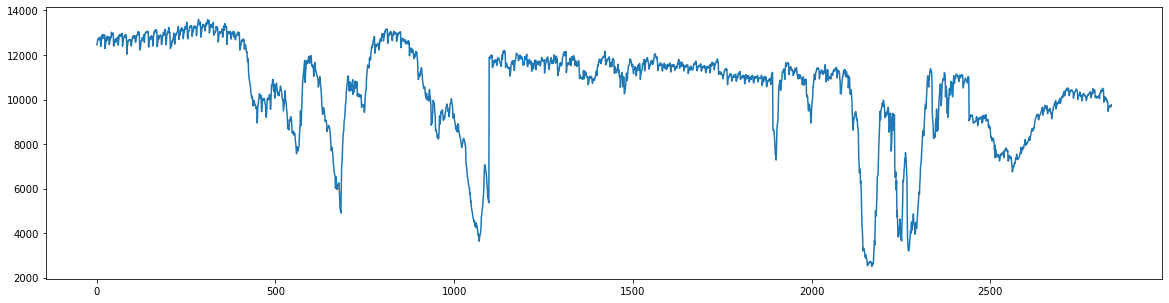

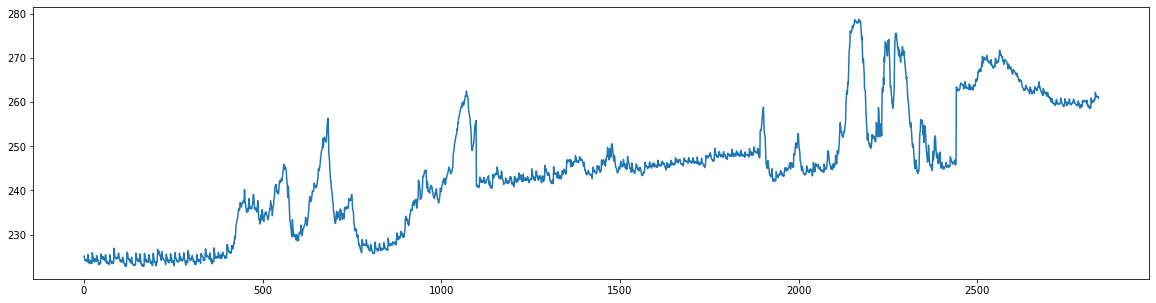

In [18]:
print(H_.shape, R_.shape)
h_ = np.max(H_[idx_1_, :], axis = 1)
k_ = np.min(R_[idx_1_, :], axis = 1)
print(h_.shape, k_.shape)

plt.figure(figsize = (20, 5))
plt.plot(h_)
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(k_)
plt.show()

# Load Weather Station Variables, IR-images, and Velocity Vectors

In [59]:
def _get_data(path):
    W_, R_, N_, S_, M0_, M1_, M2_, Y_ = [], [], [], [], [], [], [], []
    for file in os.listdir(path):
        print(file)
        x_, y_ = _load_file(r'{}\{}'.format(path, file))[0]
        for i in range(len(x_)):
            w_, r_, n_, s_, m0_, m1_, m2_ = x_[i]
            W_.append(w_[..., np.newaxis])
            R_.append(r_.flatten()[..., np.newaxis])
            N_.append(n_.flatten()[..., np.newaxis])
            S_.append(s_.flatten()[..., np.newaxis])
            M0_.append(m0_.flatten()[..., np.newaxis])
            M1_.append(m1_.flatten()[..., np.newaxis])
            M2_.append(m2_.flatten()[..., np.newaxis])
            Y_.append(np.array((y_))[..., np.newaxis] )
    return W_, R_, N_, S_, M0_, M1_, M2_, Y_

# Load up feature extraction results
W_, R_, N_, S_, M0_, M1_, M2_, Y_ = _get_data(path = r'C:\Users\Guille\Desktop\atmospheric_condition_model\data\v5')
print(len(W_), len(R_), len(N_), len(S_), len(M0_), len(M1_), len(M2_), len(Y_))

5-0_atmospheric_conditions_model_dataset.pkl
5-10_atmospheric_conditions_model_dataset.pkl
5-11_atmospheric_conditions_model_dataset.pkl
5-12_atmospheric_conditions_model_dataset.pkl
5-13_atmospheric_conditions_model_dataset.pkl
5-14_atmospheric_conditions_model_dataset.pkl
5-15_atmospheric_conditions_model_dataset.pkl
5-16_atmospheric_conditions_model_dataset.pkl
5-17_atmospheric_conditions_model_dataset.pkl
5-18_atmospheric_conditions_model_dataset.pkl
5-19_atmospheric_conditions_model_dataset.pkl
5-1_atmospheric_conditions_model_dataset.pkl
5-20_atmospheric_conditions_model_dataset.pkl
5-21_atmospheric_conditions_model_dataset.pkl
5-2_atmospheric_conditions_model_dataset.pkl
5-3_atmospheric_conditions_model_dataset.pkl
5-4_atmospheric_conditions_model_dataset.pkl
5-5_atmospheric_conditions_model_dataset.pkl
5-6_atmospheric_conditions_model_dataset.pkl
5-7_atmospheric_conditions_model_dataset.pkl
5-8_atmospheric_conditions_model_dataset.pkl
5-9_atmospheric_conditions_model_dataset.pk

In [4]:
def _append(w_, r_, n_, s_, m_, y_, x_, label):
    if y_ == label:
        x_.append([w_, r_, n_, s_, m_, y_])
    return x_

def _quanta(x_, X_, N = 410):
    if len(x_) == N:
        X_.append(x_)
        x_ = []
    return x_, X_

def _data_quantification(W_, R_, N_, S_, M_, Y_):
    X_0_, X_1_, X_2_, X_3_ = [], [], [], []
    x_0_, x_1_, x_2_, x_3_ = [], [], [], []
    for w_, r_, n_, s_, m_, y_ in zip(W_, R_, N_, S_, M_, Y_):
        x_0_ = _append(w_, r_, n_, s_, m_, y_, x_0_, label = 0)
        x_1_ = _append(w_, r_, n_, s_, m_, y_, x_1_, label = 1)
        x_2_ = _append(w_, r_, n_, s_, m_, y_, x_2_, label = 2)
        x_3_ = _append(w_, r_, n_, s_, m_, y_, x_3_, label = 3)
        x_0_, X_0_ = _quanta(x_0_, X_0_)
        x_1_, X_1_ = _quanta(x_1_, X_1_)
        x_2_, X_2_ = _quanta(x_2_, X_2_)
        x_3_, X_3_ = _quanta(x_3_, X_3_)
    return X_0_, X_1_, X_2_, X_3_


def _select_quanta(X_, N = 6):
    np.random.seed(9888)
    return [X_[i] for i in np.random.permutation(len(X_))[:N]]

X_0_, X_1_, X_2_, X_3_ = _data_quantification(W_, R_, N_, S_, M0_, Y_)
print(len(X_0_), len(X_1_), len(X_2_), len(X_3_))

X_0_ = _select_quanta(X_0_, N = 6)
X_1_ = _select_quanta(X_1_, N = 6)
X_2_ = _select_quanta(X_2_, N = 6)
X_3_ = _select_quanta(X_3_, N = 6)
print(len(X_0_), len(X_1_), len(X_2_), len(X_3_))

X_0_tr_ = X_0_[:-1]
X_1_tr_ = X_1_[:-1]
X_2_tr_ = X_2_[:-1]
X_3_tr_ = X_3_[:-1]
print(len(X_0_tr_), len(X_1_tr_), len(X_2_tr_), len(X_3_tr_))

X_0_ts_ = X_0_[-1]
X_1_ts_ = X_1_[-1]
X_2_ts_ = X_2_[-1]
X_3_ts_ = X_3_[-1]
print(len(X_0_ts_), len(X_1_ts_), len(X_2_ts_), len(X_3_ts_))

9 6 16 10
6 6 6 6
5 5 5 5
410 410 410 410


In [22]:
def _left_out_sample(i, X_0_, X_1_, X_2_, X_3_):
    idx_ = np.delete(np.arange(len(X_0_)), i)
    X_0_tr_ = [X_0_[j] for j in idx_]
    X_1_tr_ = [X_1_[j] for j in idx_]
    X_2_tr_ = [X_2_[j] for j in idx_]
    X_3_tr_ = [X_3_[j] for j in idx_]
    return X_0_tr_, X_1_tr_, X_2_tr_, X_3_tr_, X_0_[i], X_1_[i], X_2_[i], X_3_[i]


def _merge_quanta(x_):
    
    W_, R_, N_, S_, M_, Y_ = [], [], [], [], [], []
    
    for x_0, x_1, x_2, x_3, x_4, x_5 in x_:
        W_.append(x_0)
        R_.append(x_1)
        N_.append(x_2)
        S_.append(x_3)
        M_.append(x_4)
        Y_.append(x_5)
        
    W_ = np.concatenate((W_), axis = 1)
    R_ = np.concatenate((R_), axis = 1)
    N_ = np.concatenate((N_), axis = 1)
    S_ = np.concatenate((S_), axis = 1)
    M_ = np.concatenate((M_), axis = 1)
    Y_ = np.concatenate((Y_), axis = 0)
    
    return W_, R_, N_, S_, M_, Y_

def _get_val_data(x_0_, x_1_, x_2_, x_3_):
    
    w_0_, r_0_, n_0_, s_0_, m_0_, y_0_ = _merge_quanta(x_0_)
    w_1_, r_1_, n_1_, s_1_, m_1_, y_1_ = _merge_quanta(x_1_)
    w_2_, r_2_, n_2_, s_2_, m_2_, y_2_ = _merge_quanta(x_2_)
    w_3_, r_3_, n_3_, s_3_, m_3_, y_3_ = _merge_quanta(x_3_)
    
    W_ = np.concatenate((w_0_, w_1_, w_2_, w_3_), axis = 1).T
    R_ = np.concatenate((r_0_, r_1_, r_2_, r_3_), axis = 1).T
    N_ = np.concatenate((n_0_, n_1_, n_2_, n_3_), axis = 1).T
    S_ = np.concatenate((s_0_, s_1_, s_2_, s_3_), axis = 1).T
    M_ = np.concatenate((m_0_, m_1_, m_2_, m_3_), axis = 1).T
    Y_ = np.concatenate((y_0_, y_1_, y_2_, y_3_), axis = 0).T
    
    return W_, R_, N_, S_, M_, Y_

def _get_train_data(X_0_, X_1_, X_2_, X_3_):
    
    W_, R_, N_, S_, M_, Y_ = [], [], [], [], [], []

    for x_0_, x_1_, x_2_, x_3_ in zip(X_0_, X_1_, X_2_, X_3_):
        
        w_0_, r_0_, n_0_, s_0_, m_0_, y_0_ = _merge_quanta(x_0_)
        w_1_, r_1_, n_1_, s_1_, m_1_, y_1_ = _merge_quanta(x_1_)
        w_2_, r_2_, n_2_, s_2_, m_2_, y_2_ = _merge_quanta(x_2_)
        w_3_, r_3_, n_3_, s_3_, m_3_, y_3_ = _merge_quanta(x_3_)
    
        W_.append(np.concatenate((w_0_, w_1_, w_2_, w_3_), axis = 1))
        R_.append(np.concatenate((r_0_, r_1_, r_2_, r_3_), axis = 1))
        N_.append(np.concatenate((n_0_, n_1_, n_2_, n_3_), axis = 1))
        S_.append(np.concatenate((s_0_, s_1_, s_2_, s_3_), axis = 1))
        M_.append(np.concatenate((m_0_, m_1_, m_2_, m_3_), axis = 1))
        Y_.append(np.concatenate((y_0_, y_1_, y_2_, y_3_), axis = 0))
    
    W_ = np.concatenate((W_), axis = 1).T
    R_ = np.concatenate((R_), axis = 1).T
    N_ = np.concatenate((N_), axis = 1).T
    S_ = np.concatenate((S_), axis = 1).T
    M_ = np.concatenate((M_), axis = 1).T
    Y_ = np.concatenate((Y_), axis = 0).T
    
    return W_, R_, N_, S_, M_, Y_

def _get_dataset(W_, R_, N_, S_, M_, Y_):
    def __get_stats(X_):
        return np.array((np.mean(X_, axis = 1), np.std(X_, axis = 1), skew(X_, axis = 1), kurtosis(X_, axis = 1))).T
    #w_ = W_[:, [1, 2, 3] ]
    r_ = __get_stats(R_)
    n_ = __get_stats(N_)
    s_ = __get_stats(S_)
    #m_ = __get_stats(M_)
    X_ = np.concatenate((n_, r_, s_), axis = 1)
    return X_, Y_

def _find_class_cluster(y_, y_hat_):
    idx_class_cluster_ = []
    for idx_ in [y_ == 0, y_ == 1, y_ == 2, y_ == 3]:
        i_0 = np.logical_and(idx_, y_hat_ == 0).sum()
        i_1 = np.logical_and(idx_, y_hat_ == 1).sum()
        i_2 = np.logical_and(idx_, y_hat_ == 2).sum()
        i_3 = np.logical_and(idx_, y_hat_ == 3).sum()
        
        i = np.argmax(np.array((i_0, i_1, i_2, i_3))) 
        idx_class_cluster_.append(i)
    
    return idx_class_cluster_


def _score(y_, y_hat_, idx_):
    y_hat_[y_hat_ == 0] = idx_[0]
    y_hat_[y_hat_ == 1] = idx_[1]
    y_hat_[y_hat_ == 2] = idx_[2]
    y_hat_[y_hat_ == 3] = idx_[3]
    print(idx_, np.unique(y_), np.unique(y_hat_))
    print(confusion_matrix(y_, y_hat_))
    return accuracy_score(y_, y_hat_)

def _leave_one_out(X_0_, X_1_, X_2_, X_3_):
    
    for i in range(len(X_0_)):
        X_0_tr_, X_1_tr_, X_2_tr_, X_3_tr_, X_0_val_, X_1_val_, X_2_val_, X_3_val_ = _left_out_sample(i, 
                                                                                        X_0_, X_1_, X_2_, X_3_)
        
        W_, R_, N_, S_, M_, Y_ = _get_train_data(X_0_tr_, X_1_tr_, X_2_tr_, X_3_tr_)
        X_tr_, y_tr_ = _get_dataset(W_, R_, N_, S_, M_, Y_)
        
        W_, R_, N_, S_, M_, Y_ = _get_val_data(X_0_val_, X_1_val_, X_2_val_, X_3_val_)
        X_val_, y_val_ = _get_dataset(W_, R_, N_, S_, M_, Y_)
        print(i, X_tr_.shape, y_tr_.shape, X_val_.shape, y_val_.shape)
        
        _GMM = mixture.GaussianMixture(n_components = 4, init_params = 'random', n_init = 3)
        _GMM.fit(X_tr_)
        # Invert labels?
        y_tr_hat_ = _GMM.predict(X_tr_)
                
        print(_score(y_tr_, y_tr_hat_, idx_ = _find_class_cluster(y_tr_, y_tr_hat_) ))
        #y_val_hat_ = _GMM.predict(X_val_)
        
    return 

_leave_one_out(X_0_tr_, X_1_tr_, X_2_tr_, X_3_tr_)


W_, R_, N_, S_, M_, Y_ = _get_train_data(X_0_tr_, X_1_tr_, X_2_tr_, X_3_tr_)
X_tr_, y_tr_ = _get_dataset(W_, R_, N_, S_, M_, Y_)
print(X_tr_.shape, y_tr_.shape)
print(np.unique(y_tr_))

W_, R_, N_, S_, M_, Y_ = _get_val_data(X_0_ts_, X_1_ts_, X_2_ts_, X_3_ts_)
X_ts_, y_ts_ = _get_dataset(W_, R_, N_, S_, M_, Y_)
print(X_ts_.shape, y_ts_.shape)
print(np.unique(y_ts_))

0 (6560, 12) (6560,) (1640, 12) (1640,)
[1, 0, 0, 1] [0 1 2 3] [0 1]
[[1503  137    0    0]
 [1533  107    0    0]
 [1378  262    0    0]
 [1608   32    0    0]]
0.24542682926829268
1 (6560, 12) (6560,) (1640, 12) (1640,)
[2, 1, 2, 0] [0 1 2 3] [0 1 2]
[[ 445  227  968    0]
 [   6 1439  195    0]
 [  88  516 1036    0]
 [   0  445 1195    0]]
0.4451219512195122
2 (6560, 12) (6560,) (1640, 12) (1640,)
[2, 0, 1, 2] [0 1 2 3] [0 1 2]
[[ 338  892  410    0]
 [ 357 1283    0    0]
 [ 957  535  148    0]
 [  70 1570    0    0]]
0.26966463414634145
3 (6560, 12) (6560,) (1640, 12) (1640,)
[2, 1, 0, 2] [0 1 2 3] [0 1 2]
[[ 634  561  445    0]
 [ 707  893   40    0]
 [1430  178   32    0]
 [1522  118    0    0]]
0.23765243902439023
4 (6560, 12) (6560,) (1640, 12) (1640,)
[2, 1, 3, 2] [0 1 2 3] [1 2]
[[   0  262 1378    0]
 [   0  817  823    0]
 [   0  305 1335    0]
 [   0  581 1059    0]]
0.3280487804878049
(8200, 12) (8200,)
[0 1 2 3]
(1640, 12) (1640,)
[0 1 2 3]


# Find Class Indexes

In [60]:
def _get_class_index(y_):
    return np.where(y_ == 0)[0], np.where(y_ == 1)[0], np.where(y_ == 2)[0], np.where(y_ == 3)[0]

def _get_samples(idx_0_, idx_1_, idx_2_, idx_3_):
    def __get_sample(idx_):
        return idx_[np.random.permutation(idx_.shape[0])[0]]
    return __get_sample(idx_0_), __get_sample(idx_1_), __get_sample(idx_2_), __get_sample(idx_3_)

def _split_samples(idx_0_, idx_1_, idx_2_, idx_3_, N_val, N_ts):
    idx_tr_  = [idx_0_[:-(N_val + N_ts)], idx_1_[:-(N_val + N_ts)], idx_2_[:-(N_val + N_ts)], idx_3_[:-(N_val + N_ts)]]
    idx_val_ = np.concatenate((idx_0_[-(N_val + N_ts):-N_ts], idx_1_[-(N_val + N_ts):-N_ts], 
                               idx_2_[-(N_val + N_ts):-N_ts], idx_3_[-(N_val + N_ts):-N_ts]), axis = 0)
    
    idx_ts_ = np.concatenate((idx_0_[-N_ts:], idx_1_[-N_ts:], idx_2_[-N_ts:], idx_3_[-N_ts:]), axis = 0)

    return idx_tr_, idx_val_, idx_ts_

W_  = np.concatenate((W_), axis = 1).T
R_  = np.concatenate((R_), axis = 1).T
N_  = np.concatenate((N_), axis = 1).T
S_  = np.concatenate((S_), axis = 1).T
M0_ = np.concatenate((M0_), axis = 1).T
M1_ = np.concatenate((M1_), axis = 1).T
M2_ = np.concatenate((M2_), axis = 1).T
Y_  = np.concatenate((Y_), axis = 0)
print(W_.shape, R_.shape, N_.shape, S_.shape, M0_.shape, M1_.shape, M2_.shape, Y_.shape)

idx_0_, idx_1_, idx_2_, idx_3_ = _get_class_index(Y_)
print(idx_0_.shape, idx_1_.shape, idx_2_.shape, idx_3_.shape)

idx_tr_, idx_val_, idx_ts_ = _split_samples(idx_0_, idx_1_, idx_2_, idx_3_, 1000, 250)
print(idx_tr_[0].shape, idx_tr_[1].shape, idx_tr_[2].shape, idx_tr_[3].shape)
print(idx_val_.shape, idx_ts_.shape)

M0_ = np.nan_to_num(M0_)
M1_ = np.nan_to_num(M1_)
M2_ = np.nan_to_num(M2_)

print(np.min(R_),  np.max(R_),  np.min(N_), np.max(N_),  np.min(S_),np.max(S_))
print(np.min(M0_), np.max(M0_), np.min(M1_), np.max(M1_), np.min(M2_), np.max(M2_))

(17870, 11) (17870, 4800) (17870, 4800) (17870, 4800) (17870, 4800) (17870, 4800) (17870, 4800) (17870,)
(3944,) (2840,) (6910,) (4176,)
(2694,) (1590,) (5660,) (2926,)
(4000,) (1000,)
222.8 450.58 0.0 116.07674574844914 -1167.1901640991891 4197.260418254315
6.261160219980713e-06 31.28325491941417 3.642432922762665e-05 70.86440409854033 6.9004817e-13 3017464.5


In [61]:
print(W_[0, :])

[ 1.77372036e-01 -1.04740815e+01  7.70128000e+02  4.44888443e+01
  2.10807397e+01  1.41047500e+02  1.05995628e+00  3.45927752e+02
  3.66668292e+02  1.80714136e+00  3.46106907e+00]


-29.443987500000503 218.7531666666664
-61.80377913632629 83.11512578398346
-2478.6835129783085 3338.6647898468336


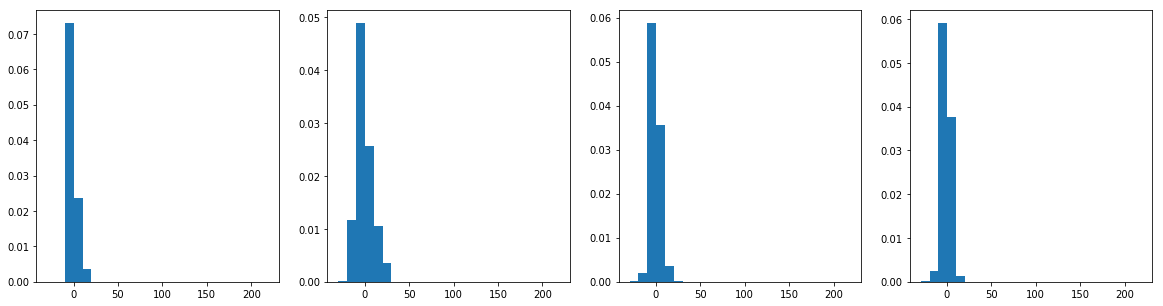

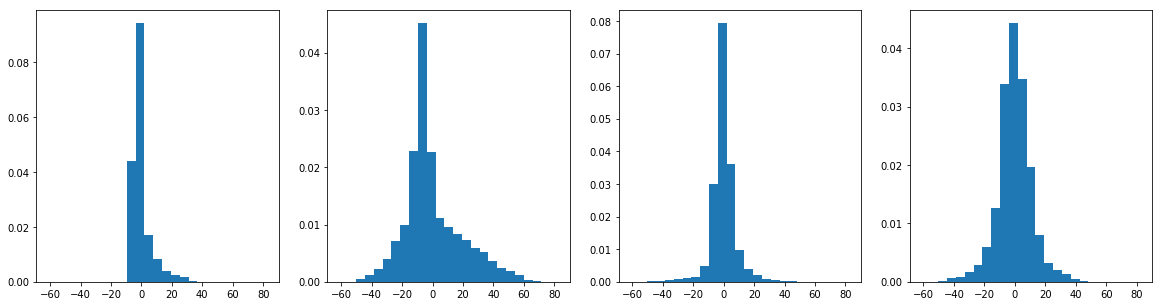

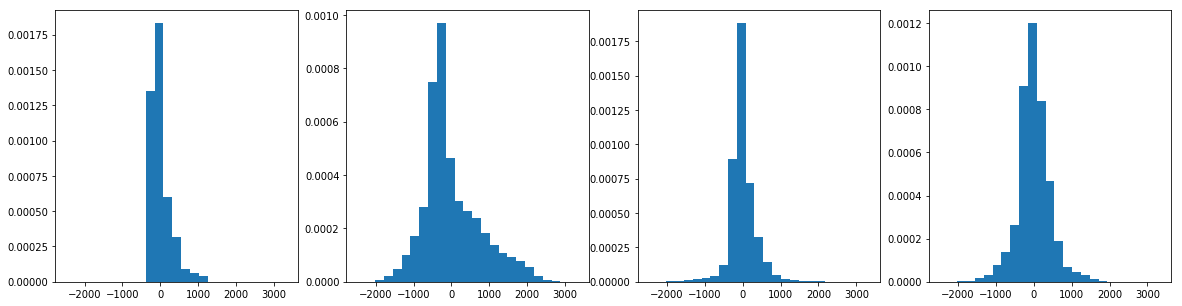

In [24]:
def _display_hist(X_, idx_):
    plt.figure(figsize = (20, 5))
    plt.subplot(141)
    plt.hist(X_[idx_[0], :].flatten(), 25, range = (np.min(X_), np.max(X_)), density = True)
    plt.subplot(142)
    plt.hist(X_[idx_[1], :].flatten(), 25, range = (np.min(X_), np.max(X_)), density = True)
    plt.subplot(143)
    plt.hist(X_[idx_[2], :].flatten(), 25, range = (np.min(X_), np.max(X_)), density = True)
    plt.subplot(144)
    plt.hist(X_[idx_[3], :].flatten(), 25, range = (np.min(X_), np.max(X_)), density = True)
    plt.show()
    
R_prime_ = R_ - np.tile(np.mean(R_, axis = 1)[..., np.newaxis], (1, 4800))
print(np.min(R_prime_), np.max(R_prime_))

N_prime_ = N_ - np.tile(np.mean(N_, axis = 1)[..., np.newaxis], (1, 4800))
print(np.min(N_prime_), np.max(N_prime_))

S_prime_ = S_ - np.tile(np.mean(S_, axis = 1)[..., np.newaxis], (1, 4800))
print(np.min(S_prime_), np.max(S_prime_))

_display_hist(R_prime_, idx_tr_)
_display_hist(N_prime_, idx_tr_)
_display_hist(S_prime_, idx_tr_)

In [168]:
def _get_histograms(X_, n_bins, low_lim, up_lim):
    N  = X_.shape[0]
    Y_ = np.zeros((N, n_bins)) 
    for x_, i in zip(X_, range(N)):
        Y_[i, :] = np.histogram(x_, bins = n_bins, range = (low_lim, up_lim), density = False)[0]
    return Y_

def _infer_normal_distribution(X_, idx_0_, idx_1_, idx_2_, idx_3_, reg_term):
    def __infer_parameters(X_):
        return np.mean(X_, axis = 0), np.cov(X_.T)
    def __normal_distribution(mu_, sig_):
        return multivariate_normal(mu_, sig_ + np.eye(sig_.shape[0])*reg_term)
    
    mu_0_, sig_0_ = __infer_parameters(X_[idx_0_, :])
    mu_1_, sig_1_ = __infer_parameters(X_[idx_1_, :])
    mu_2_, sig_2_ = __infer_parameters(X_[idx_2_, :])
    mu_3_, sig_3_ = __infer_parameters(X_[idx_3_, :])
    
    _N_0 = __normal_distribution(mu_0_, sig_0_)
    _N_1 = __normal_distribution(mu_1_, sig_1_)
    _N_2 = __normal_distribution(mu_2_, sig_2_)
    _N_3 = __normal_distribution(mu_3_, sig_3_)
    return _N_0, _N_1, _N_2, _N_3 

def _eval_distributions(_N_0, _N_1, _N_2, _N_3, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis],
                           _N_2.logpdf(x_)[:, np.newaxis], _N_3.logpdf(x_)[:, np.newaxis]), axis = 1)

# 30 - 10 - 20
N_0 = 30
N_1 = 10
N_2 = 20

x_0_ = np.linspace(5, 50, N_0, dtype = int)
x_1_ = np.linspace(-1., -30., N_1)
x_2_ = np.linspace(1., 219, N_2)

E_ = np.zeros((N_0, N_1, N_2))

for x_0, i in zip(x_0_, range(N_0)):
    for x_1, j in zip(x_1_, range(N_1)):
        for x_2, k in zip(x_2_, range(N_2)):

            r_ = _get_histograms(R_prime_, n_bins = x_0, low_lim = x_1, up_lim = x_2)

            try:
                _N_r_0, _N_r_1, _N_r_2, _N_r_3 = _infer_normal_distribution(r_, idx_tr_[0], idx_tr_[1], 
                                                                            idx_tr_[2], idx_tr_[3], reg_term = 0.)


                y_hat_ = np.argmax(_eval_distributions(_N_r_0, _N_r_1, _N_r_2, _N_r_3, r_), axis = 1)

                E_[i, j, k] = accuracy_score(y_[idx_val_], y_hat_[idx_val_])
                print(x_0, x_1, x_2, E_[i, j, k], accuracy_score(y_[idx_ts_], y_hat_[idx_ts_]))
                
            except:
                pass
    
i_, j_, k_ = np.where(E_ == np.max(E_))
print(x_0_[i_[0]], x_1_[j_[0]], x_2_[k_[0]], np.max(E_))

# Raw Image Optimal Configuration = 6 -1.0 12.473684210526315 0.71125 0.739

5 -1.0 1.0 0.6575 0.634
5 -1.0 12.473684210526315 0.6215 0.678
5 -1.0 23.94736842105263 0.41725 0.454
5 -1.0 35.421052631578945 0.452 0.504
5 -1.0 46.89473684210526 0.53175 0.58
5 -1.0 58.368421052631575 0.52475 0.607
5 -1.0 69.84210526315789 0.549 0.621
5 -1.0 81.3157894736842 0.503 0.593
5 -1.0 92.78947368421052 0.53975 0.489
5 -1.0 104.26315789473684 0.54725 0.474
5 -1.0 115.73684210526315 0.53425 0.462
5 -1.0 127.21052631578947 0.5305 0.469
5 -1.0 138.68421052631578 0.53375 0.479
5 -1.0 150.15789473684208 0.546 0.508
5 -1.0 161.6315789473684 0.50525 0.533
5 -1.0 173.10526315789474 0.5205 0.536
5 -1.0 184.57894736842104 0.5375 0.509
5 -1.0 196.05263157894734 0.4695 0.51
5 -1.0 207.52631578947367 0.53875 0.586
5 -1.0 219.0 0.484 0.529
5 -4.222222222222222 1.0 0.6365 0.586
5 -4.222222222222222 12.473684210526315 0.57 0.566
5 -4.222222222222222 23.94736842105263 0.4775 0.442
5 -4.222222222222222 35.421052631578945 0.46125 0.491
5 -4.222222222222222 46.89473684210526 0.46075 0.472
5 -4.

KeyboardInterrupt: 

In [167]:
def _get_histograms(M_, n_bins, range_):
    N  = M_.shape[0]
    X_ = np.zeros((N, n_bins)) 
    for x_, i in zip(M_, range(N)):
        X_[i, :] = np.histogram(x_, bins = n_bins, range = range_, density = False)[0]
    return X_

def _infer_normal_distribution(X_, idx_, reg_term):
    def __infer_parameters(X_):
        return np.mean(X_, axis = 0), np.cov(X_.T)
    def __normal_distribution(mu_, sig_):
        return multivariate_normal(mu_, sig_ + np.eye(sig_.shape[0])*reg_term)
    mu_, sig_ = __infer_parameters(X_[idx_, :])
    return __normal_distribution(mu_, sig_)

def _eval_distribution(_N_0, _N_1, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis]), axis = 1)

y_p_ = y_.copy()
y_p_[y_ != 0.] = 1.

idx_123_ = np.concatenate((idx_tr_[1], idx_tr_[2], idx_tr_[3]), axis = 0)

N_0 = 25
N_1 = 25

x_0_ = np.linspace(5, 30, N_0, dtype = int)
x_1_ = np.linspace(0.01, 1., N_1)

E_ = np.zeros((N_0, N_1))

for x_0, i in zip(x_0_, range(N_0)):
    for x_1, j in zip(x_1_, range(N_1)):

        m0_ = _get_histograms(M0_, n_bins = x_0, range_ = (0., x_1))

        try:
            _N_m0_0 = _infer_normal_distribution(m0_, idx_tr_[0], reg_term = 0.)
            _N_m0_1 = _infer_normal_distribution(m0_, idx_123_, reg_term = 0.)

            Z_m0_ = _eval_distribution(_N_m0_0, _N_m0_1, m0_)
            l_m0_ = np.argmax(Z_m0_, axis = 1)

            E_[i, j] = accuracy_score(y_p_[idx_val_], l_m0_[idx_val_])
            print(x_0, x_1, E_[i, j], accuracy_score(y_p_[idx_ts_], l_m0_[idx_ts_]))
        
        except:
            pass
        
i_, j_ = np.where(E_ == np.max(E_))
print(x_0_[i_[0]], x_1_[j_[0]])
# Lukas-kanade Configuration = 19 0.2575 0.776 0.796

5 0.01 0.74125 0.755
5 0.051250000000000004 0.76025 0.795
5 0.0925 0.763 0.805
5 0.13375 0.7605 0.811
5 0.17500000000000002 0.76675 0.8
5 0.21625000000000003 0.761 0.795
5 0.2575 0.76325 0.768
5 0.29875 0.76375 0.743
5 0.34 0.7495 0.718
5 0.38125000000000003 0.7345 0.686
5 0.42250000000000004 0.7175 0.661
5 0.46375000000000005 0.70475 0.654
5 0.505 0.70075 0.632
5 0.54625 0.69725 0.62
5 0.5875 0.6955 0.609
5 0.62875 0.69125 0.608
5 0.67 0.68725 0.605
5 0.71125 0.689 0.591
5 0.7525000000000001 0.68975 0.586
5 0.7937500000000001 0.6905 0.581
5 0.8350000000000001 0.68725 0.582
5 0.8762500000000001 0.6865 0.578
5 0.9175000000000001 0.6785 0.579
5 0.9587500000000001 0.6745 0.582
5 1.0 0.6715 0.568
6 0.01 0.74225 0.741
6 0.051250000000000004 0.7555 0.781
6 0.0925 0.7565 0.798
6 0.13375 0.765 0.81
6 0.17500000000000002 0.75925 0.796
6 0.21625000000000003 0.76125 0.786
6 0.2575 0.76825 0.78
6 0.29875 0.7645 0.755
6 0.34 0.7485 0.748
6 0.38125000000000003 0.73875 0.705
6 0.42250000000000004 0.7

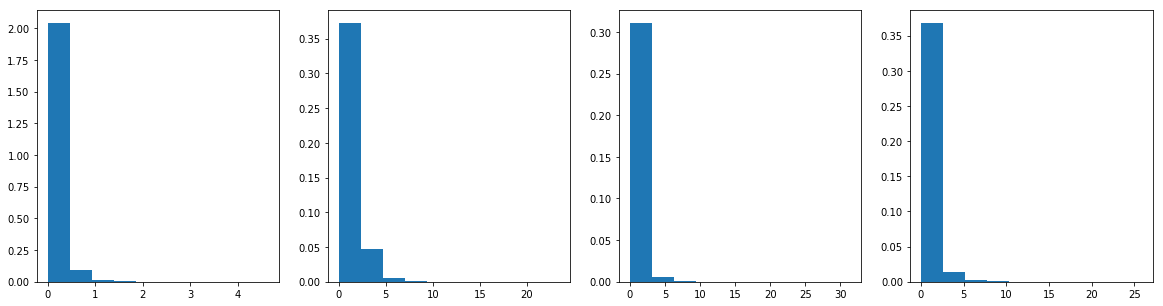

(17870, 19)


In [169]:
def _get_histograms(M_, n_bins, range_):
    N  = M_.shape[0]
    X_ = np.zeros((N, n_bins)) 
    for x_, i in zip(M_, range(N)):
        X_[i, :] = np.histogram(x_, bins = n_bins, range = range_, density = False)[0]
    return X_

plt.figure(figsize = (20, 5))
plt.subplot(141)
plt.hist(M0_[idx_tr_[0], :].flatten(), 10, density = True)
plt.subplot(142)
plt.hist(M0_[idx_tr_[1], :].flatten(), 10, density = True)
plt.subplot(143)
plt.hist(M0_[idx_tr_[2], :].flatten(), 10, density = True)
plt.subplot(144)
plt.hist(M0_[idx_tr_[3], :].flatten(), 10, density = True)
plt.show()

# Lukas-kanade Configuration = 19 0.2575 0.776 0.796
m0_ = _get_histograms(M0_, n_bins = 19, range_ = (0., 0.2575))
print(m0_.shape)
#m1_ = _get_histograms(M1_, n_bins = 5, range_ = (0., 0.125))
#print(m1_.shape)
#m2_ = _get_histograms(M2_, n_bins = 5, range_ = (0., 0.125))
#print(m2_.shape)

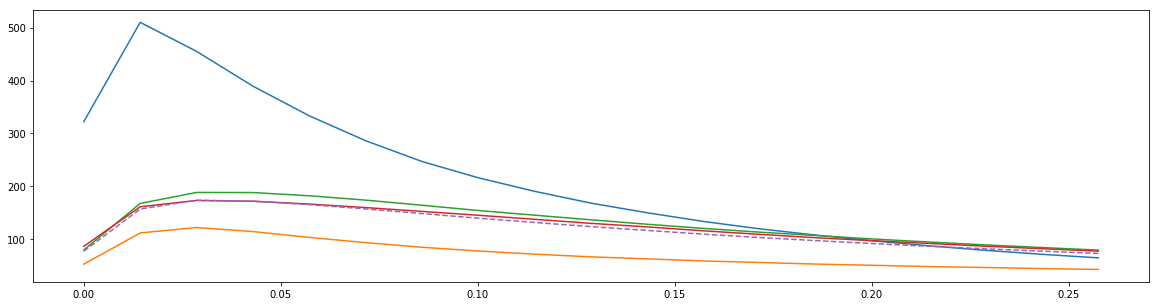

In [170]:
def _infer_normal_distribution(X_, idx_, reg_term):
    def __infer_parameters(X_):
        return np.mean(X_, axis = 0), np.cov(X_.T)
    def __normal_distribution(mu_, sig_):
        return multivariate_normal(mu_, sig_ + np.eye(sig_.shape[0])*reg_term)
    mu_, sig_ = __infer_parameters(X_[idx_, :])
    return __normal_distribution(mu_, sig_)

idx_0_   = idx_tr_[0]
idx_123_ = np.concatenate((idx_tr_[1], idx_tr_[2], idx_tr_[3]), axis = 0)

x_ = np.linspace(0., 0.2575, 19)

plt.figure(figsize = (20, 5))
plt.plot(x_, np.mean(m0_[idx_tr_[0], :], axis = 0))
plt.plot(x_, np.mean(m0_[idx_tr_[1], :], axis = 0))
plt.plot(x_, np.mean(m0_[idx_tr_[2], :], axis = 0))
plt.plot(x_, np.mean(m0_[idx_tr_[3], :], axis = 0))
plt.plot(x_, np.mean(m0_[idx_123_, :], axis = 0), '--')
plt.show()
               
_N_m0_0 = _infer_normal_distribution(m0_, idx_0_, reg_term = 1e-5)
_N_m0_1 = _infer_normal_distribution(m0_, idx_123_, reg_term = 1e-5)

#_N_m1_0 = _infer_normal_distribution(m1_, idx_0_, reg_term = 1e-3)
#_N_m1_1 = _infer_normal_distribution(m1_, idx_123_, axis = 0), reg_term = 1e-3)

#_N_m2_0 = _infer_normal_distribution(m2_, idx_0_, reg_term = 1e-3)
#_N_m2_1 = _infer_normal_distribution(m2_, idx_123_, axis = 0), reg_term = 1e-3)

In [171]:
def _eval_distribution(_N_0, _N_1, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis]), axis = 1)

y_p_ = y_.copy()
y_p_[y_ != 0.] = 1.

Z_m0_ = _eval_distribution(_N_m0_0, _N_m0_1, m0_)
y_m0_hat_ = np.argmax(Z_m0_, axis = 1)

print(accuracy_score(y_p_[idx_val_], y_m0_hat_[idx_val_]))
print(accuracy_score(y_p_[idx_ts_], y_m0_hat_[idx_ts_]))

print(confusion_matrix(y_p_[idx_val_], y_m0_hat_[idx_val_]))
print(confusion_matrix(y_p_[idx_ts_], y_m0_hat_[idx_ts_]))

0.776
0.796
[[ 698  302]
 [ 594 2406]]
[[181  69]
 [135 615]]


-29.443987500000503 218.7531666666664


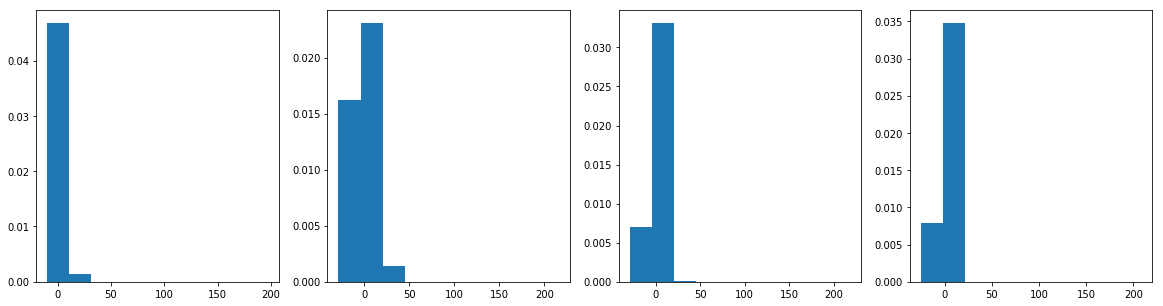

(17870, 6)


In [172]:
def _get_histograms(M_, n_bins, range_):
    N  = M_.shape[0]
    X_ = np.zeros((N, n_bins)) 
    for x_, i in zip(M_, range(N)):
        X_[i, :] = np.histogram(x_, bins = n_bins, range = range_, density = True)[0]
    return X_

R_prime_ = R_ - np.tile(np.mean(R_, axis = 1)[..., np.newaxis], (1, 4800))
print(np.min(R_prime_), np.max(R_prime_))

#N_prime_ = N_ - np.tile(np.mean(N_, axis = 1)[..., np.newaxis], (1, 4800))
#print(np.min(N_prime_), np.max(N_prime_))

#S_prime_ = S_ - np.tile(np.mean(S_, axis = 1)[..., np.newaxis], (1, 4800))
#print(np.min(S_prime_), np.max(S_prime_))

plt.figure(figsize = (20, 5))
plt.subplot(141)
plt.hist(R_prime_[idx_tr_[0], :].flatten(), 10, density = True)
plt.subplot(142)
plt.hist(R_prime_[idx_tr_[1], :].flatten(), 10, density = True)
plt.subplot(143)
plt.hist(R_prime_[idx_tr_[2], :].flatten(), 10, density = True)
plt.subplot(144)
plt.hist(R_prime_[idx_tr_[3], :].flatten(), 10, density = True)
plt.show()

# Raw Image Optimal Configuration = 6 -1.0 12.473684210526315 0.71125 0.739
r_ = _get_histograms(R_prime_, n_bins = 6, range_ = (-1.0, 12.473684210526315))
print(r_.shape)
#n_ = _get_histograms(N_prime_, n_bins, range_)
#print(n_.shape)
#s_ = _get_histograms(S_prime_, n_bins, range_)
#print(s_.shape)

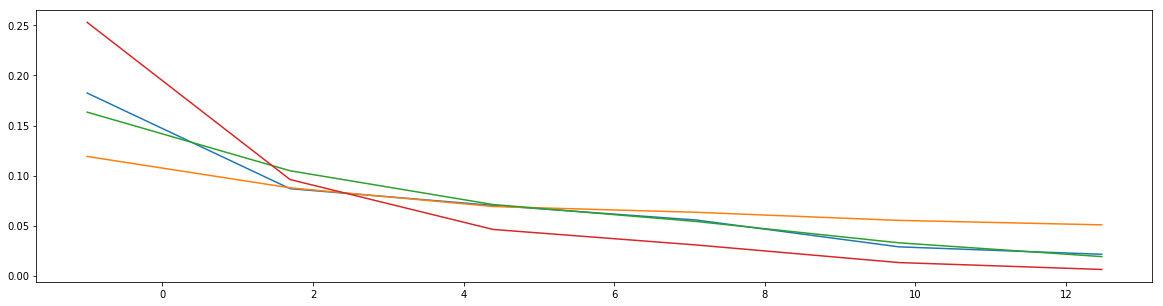

In [173]:
def _infer_normal_distribution(X_, idx_0_, idx_1_, idx_2_, idx_3_, reg_term):
    def __infer_parameters(X_):
        return np.mean(X_, axis = 0), np.cov(X_.T)
    def __normal_distribution(mu_, sig_):
        return multivariate_normal(mu_, sig_ + np.eye(sig_.shape[0])*reg_term)
    
    mu_0_, sig_0_ = __infer_parameters(X_[idx_0_, :])
    mu_1_, sig_1_ = __infer_parameters(X_[idx_1_, :])
    mu_2_, sig_2_ = __infer_parameters(X_[idx_2_, :])
    mu_3_, sig_3_ = __infer_parameters(X_[idx_3_, :])
    
    _N_0 = __normal_distribution(mu_0_, sig_0_)
    _N_1 = __normal_distribution(mu_1_, sig_1_)
    _N_2 = __normal_distribution(mu_2_, sig_2_)
    _N_3 = __normal_distribution(mu_3_, sig_3_)
    return _N_0, _N_1, _N_2, _N_3 

x_ = np.linspace(-1.0, 12.473684210526315, 6)

plt.figure(figsize = (20, 5))
plt.plot(x_, np.mean(r_[idx_tr_[0], :], axis = 0))
plt.plot(x_, np.mean(r_[idx_tr_[1], :], axis = 0))
plt.plot(x_, np.mean(r_[idx_tr_[2], :], axis = 0))
plt.plot(x_, np.mean(r_[idx_tr_[3], :], axis = 0))
plt.show()

_N_r_0, _N_r_1, _N_r_2, _N_r_3 = _infer_normal_distribution(r_, idx_tr_[0], idx_tr_[1], idx_tr_[2], idx_tr_[3], 
                                                            reg_term = 1e-3)
#_N_n_0, _N_n_1, _N_n_2, _N_n_3 = _infer_normal_distribution(n_, idx_0_, idx_1_, idx_2_, idx_3_, reg_term = 1e-3)
#_N_s_0, _N_s_1, _N_s_2, _N_s_3 = _infer_normal_distribution(s_, idx_0_, idx_1_, idx_2_, idx_3_, reg_term = 1e-3)

In [247]:
def _eval_distributions(_N_0, _N_1, _N_2, _N_3, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis] + 0.9,
                           _N_2.logpdf(x_)[:, np.newaxis] + .25, _N_3.logpdf(x_)[:, np.newaxis]), axis = 1)

Z_r_ = _eval_distributions(_N_r_0, _N_r_1, _N_r_2, _N_r_3, r_)
y_r_hat_ = np.argmax(Z_r_, axis = 1)

print(accuracy_score(y_[idx_val_], y_r_hat_[idx_val_]))
print(accuracy_score(y_[idx_ts_], y_r_hat_[idx_ts_]))

print(confusion_matrix(y_[idx_val_], y_r_hat_[idx_val_]))
print(confusion_matrix(y_[idx_ts_], y_r_hat_[idx_ts_]))

0.771
0.793
[[ 919   27   54    0]
 [ 133  598  171   98]
 [ 279  150  567    4]
 [   0    0    0 1000]]
[[249   0   1   0]
 [ 69 165  16   0]
 [ 78  12 129  31]
 [  0   0   0 250]]


In [250]:
y_hat_ = np.zeros(y_[idx_ts_].shape)

idx_0_   = y_r_hat_[idx_ts_] == 0
idx_123_ = y_m0_hat_[idx_ts_] == 1
print(idx_0_.shape, idx_123_.shape, y_m0_hat_[idx_ts_].shape)

y_r_hat_prime_ = np.argmax(Z_r_[:, 1:], axis = 1) + 1
print(y_m0_hat_.shape, y_r_hat_prime_.shape)

y_hat_[idx_0_]   = y_r_hat_[idx_ts_][idx_0_]
y_hat_[idx_123_] = y_r_hat_prime_[idx_ts_][idx_123_]

print(accuracy_score(y_[idx_ts_], y_hat_))
print(confusion_matrix(y_[idx_ts_], y_hat_))

(1000,) (1000,) (1000,)
(17870,) (17870,)
0.677
[[181   0  69   0]
 [  4 164  82   0]
 [ 48  14 165  23]
 [ 83   0   0 167]]


In [175]:
files_path = r'C:\Users\Guille\Desktop\atmospheric_condition_model\model'
files_name = r'atmospheric_conditions_model_v8.pkl'
_save_file(X_ = [[_N_m0_0, _N_m0_1], [_N_r_0, _N_r_1, _N_r_2, _N_r_3]],
           name = r'{}\{}'.format(files_path, files_name) )

# files_path = r'C:\Users\Guille\Desktop\atmospheric_condition_model\model'
# files_name = r'atmospheric_conditions_model_v1.pkl'
# _save_file(X_ = [[_N_r_0, _N_r_1, _N_r_2, _N_r_3], [_N_n_0, _N_n_1, _N_n_2, _N_n_3], [_N_f_0, _N_f_1, _N_f_2, _N_f_3]],
#            name = r'{}\{}'.format(files_path, files_name) )

C:\Users\Guille\Desktop\atmospheric_condition_model\model\atmospheric_conditions_model_v8.pkl


In [61]:
def _infer_gamma_distribution(X_, idx_):
    x_ = X_[idx_, :].flatten()
    theta_ = gamma.fit(x_)
    return gamma(theta_[0], loc = theta_[1], scale = theta_[2])

def _get_histograms(M_, n_bins, range_):
    N  = M_.shape[0]
    X_ = np.zeros((N, n_bins)) 
    for x_, i in zip(M_, range(N)):
        X_[i, :] = np.histogram(x_, bins = n_bins, range = range_, density = True)[0]
    return X_


m0_ = _get_histograms(M0_, n_bins = 10, range_ = (0.01, 4.))

x_ = np.linspace(0.01, 4., 10)

idx_123_ = np.concatenate((idx_tr_[1], idx_tr_[2], idx_tr_[3]), axis = 0)

_G_m0_0 = _infer_gamma_distribution(M0_, idx_tr_[0])
_G_m0_1 = _infer_gamma_distribution(M0_, idx_123_)

z_0_ = _G_m0_0.pdf(x_[:, np.newaxis])
z_1_ = _G_m0_1.pdf(x_[:, np.newaxis])

# plt.figure(figsize = (20, 5))
# plt.plot(x_, np.mean(m0_[idx_tr_[0], :], axis = 0))
# plt.plot(x_, np.mean(m0_[idx_tr_[1], :], axis = 0))
# plt.plot(x_, np.mean(m0_[idx_tr_[2], :], axis = 0))
# plt.plot(x_, np.mean(m0_[idx_tr_[3], :], axis = 0))
# plt.plot(x_, np.mean(m0_[idx_123_, :], axis = 0), '--')
# plt.show()

plt.figure(figsize = (20, 5))
plt.plot(x_, z_0_)
plt.plot(x_, z_1_)
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(x_, np.mean(m0_[idx_tr_[0], :], axis = 0))
plt.plot(x_, np.mean(m0_[idx_123_, :], axis = 0))
plt.show()

KeyboardInterrupt: 

In [29]:
def _eval_distributions(_N_0, _N_1, _N_2, _N_3, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis],
                           _N_2.logpdf(x_)[:, np.newaxis], _N_3.logpdf(x_)[:, np.newaxis]), axis = 1)

def _eval_distribution(_N_0, _N_1, x_):
    return np.concatenate((_N_0.logpdf(x_)[:, np.newaxis], _N_1.logpdf(x_)[:, np.newaxis]), axis = 1)

Z_r_ = _eval_distributions(_N_r_0, _N_r_1, _N_r_2, _N_r_3, r_)
Z_n_ = _eval_distributions(_N_n_0, _N_n_1, _N_n_2, _N_n_3, n_)
Z_s_ = _eval_distributions(_N_s_0, _N_s_1, _N_s_2, _N_s_3, s_)

l_r_ = np.argmax(Z_r_, axis = 1)
l_n_ = np.argmax(Z_n_, axis = 1)
l_s_ = np.argmax(Z_s_, axis = 1)

l_ = np.argmax(Z_r_ + Z_n_ + Z_s_, axis = 1)            

Z_m0_ = _eval_distribution(_N_m0_0, _N_m0_1, m0_)
Z_m1_ = _eval_distribution(_N_m1_0, _N_m1_1, m0_)
Z_m2_ = _eval_distribution(_N_m2_0, _N_m2_1, m0_)

l_m0_ = np.argmax(Z_m0_, axis = 1)
l_m1_ = np.argmax(Z_m1_, axis = 1)
l_m2_ = np.argmax(Z_m2_, axis = 1)

In [30]:
print(accuracy_score(y_, l_s_))
print(confusion_matrix(y_, l_s_))
y_p_ = y_.copy()
l_s_p_ = l_s_.copy()
y_p_[y_ != 0.] = 1.
l_s_p_[l_s_ != 0.] = 1.

print(accuracy_score(y_p_, l_s_p_))
print(confusion_matrix(y_p_, l_s_p_))

print(accuracy_score(y_p_, l_m0_))
print(confusion_matrix(y_p_, l_m0_))

print(accuracy_score(y_p_, l_m1_))
print(confusion_matrix(y_p_, l_m1_))

print(accuracy_score(y_p_, l_m2_))
print(confusion_matrix(y_p_, l_m2_))

# 0.5484611080022384
# 0.5136541689983212

0.5658086177951874
[[3872   48   24    0]
 [ 365 1186   49 1240]
 [3040  690 1251 1929]
 [ 103  203   68 3802]]
0.799664241745943
[[ 3872    72]
 [ 3508 10418]]
0.5484611080022384
[[3822  122]
 [7947 5979]]
0.5058757694459989
[[3850   94]
 [8736 5190]]
0.7747062115277
[[ 2843  1101]
 [ 2925 11001]]


In [66]:
def _sort_probability(Z_):
    return np.argsort(Z_, axis = 0)[::-1]

idx_ = _sort_probability(Z_)

N_samples = 2000
_N_r_0, _N_n_0, _N_f_0 = _infer_normal_distribution(r_, n_, f_, idx_[:N_samples, 0], reg_term = 1e-2)
_N_r_1, _N_n_1, _N_f_1 = _infer_normal_distribution(r_, n_, f_, idx_[:N_samples, 1], reg_term = 1e-2)
_N_r_2, _N_n_2, _N_f_2 = _infer_normal_distribution(r_, n_, f_, idx_[:N_samples, 2], reg_term = 1e-2)
_N_r_3, _N_n_3, _N_f_3 = _infer_normal_distribution(r_, n_, f_, idx_[:N_samples, 3], reg_term = 1e-2)

Z_r_ = _eval_distributions(_N_r_0, _N_r_1, _N_r_2, _N_r_3, r_)
Z_n_ = _eval_distributions(_N_n_0, _N_n_1, _N_n_2, _N_n_3, n_)
Z_f_ = _eval_distributions(_N_f_0, _N_f_1, _N_f_2, _N_f_3, f_)
Z_ = Z_r_ + Z_n_ + Z_f_
l_sel_r_ = np.argmax(Z_r_, axis = 1)
l_sel_n_ = np.argmax(Z_n_, axis = 1)
l_sel_f_ = np.argmax(Z_f_, axis = 1)
l_sel_  = np.argmax(Z_, axis = 1)

0.0 1.0 2.0 3.0
0 1 0 0
0 1 0 0
0 1 1 1
0 3 1 3


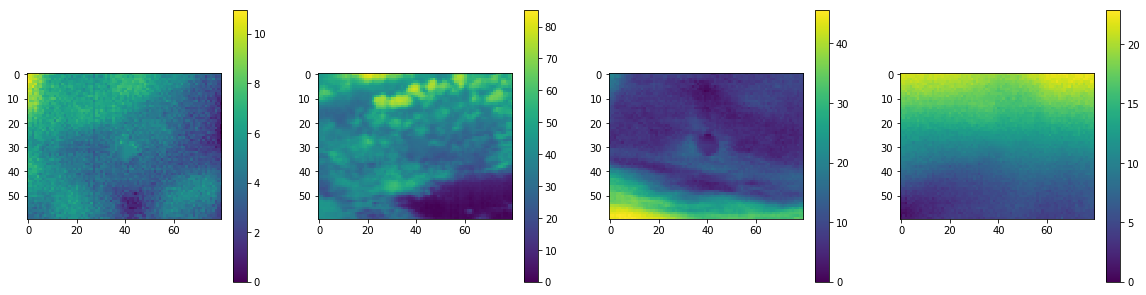

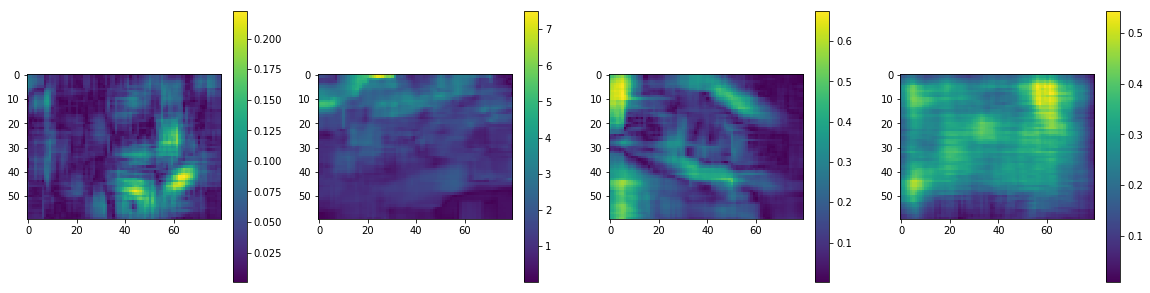

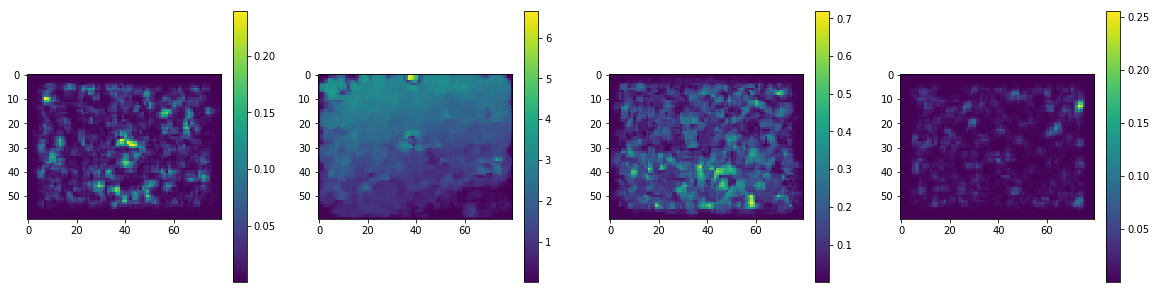

In [105]:
i_0, i_1, i_2, i_3 = _get_samples(idx_0_, idx_1_, idx_2_, idx_3_)

#print(i_0, i_1, i_2, i_3)
print(y_[i_0], y_[i_1], y_[i_2], y_[i_3])

print(l_m0_[i_0], l_m0_[i_1], l_m0_[i_2], l_m0_[i_3])
print(l_m1_[i_0], l_m1_[i_1], l_m1_[i_2], l_m1_[i_3])
print(l_m2_[i_0], l_m2_[i_1], l_m2_[i_2], l_m2_[i_3])

print(l_s_[i_0], l_s_[i_1], l_s_[i_2], l_s_[i_3])

plt.figure(figsize = (20, 5))
plt.subplot(141)
plt.imshow(N_[i_0, :].reshape(60, 80))
plt.colorbar()
plt.subplot(142)
plt.imshow(N_[i_1, :].reshape(60, 80))
plt.colorbar()
plt.subplot(143)
plt.imshow(N_[i_2, :].reshape(60, 80))
plt.colorbar()
plt.subplot(144)
plt.imshow(N_[i_3, :].reshape(60, 80))
plt.colorbar()
plt.show()

plt.figure(figsize = (20, 5))
plt.subplot(141)
plt.imshow(M0_[i_0, :].reshape(60, 80))
plt.colorbar()
plt.subplot(142)
plt.imshow(M0_[i_1, :].reshape(60, 80))
plt.colorbar()
plt.subplot(143)
plt.imshow(M0_[i_2, :].reshape(60, 80))
plt.colorbar()
plt.subplot(144)
plt.imshow(M0_[i_3, :].reshape(60, 80))
plt.colorbar()
plt.show()

plt.figure(figsize = (20, 5))
plt.subplot(141)
plt.imshow(M2_[i_0, :].reshape(60, 80))
plt.colorbar()
plt.subplot(142)
plt.imshow(M2_[i_1, :].reshape(60, 80))
plt.colorbar()
plt.subplot(143)
plt.imshow(M2_[i_2, :].reshape(60, 80))
plt.colorbar()
plt.subplot(144)
plt.imshow(M2_[i_3, :].reshape(60, 80))
plt.colorbar()
plt.show()

In [106]:
Z_m0_ = _eval_distribution(_N_m0_0, _N_m0_1, m0_)

l_m0_ = np.argmax(Z_m0_, axis = 1)

print(accuracy_score(y_p_, l_m0_))
print(confusion_matrix(y_p_, l_m0_))

# 0.6360940123111359
# 0.6450475657526581
# 0.659876888640179
# 0.7052602126468942
# 0.7377728035814214
# 0.7593732512590935
# 0.765752658086178
# 0.7667599328483492
# 0.7728595411303861
# 0.7746502518186905
# 0.7801343033016228

for bins in range(35, 45, 1):
    
    r_, n_, s_ = _get_histograms(R_, N_, S_, n_bins = bins)
    print(r_.shape, n_.shape, s_.shape)

    _N_s_0, _N_s_1, _N_s_2, _N_s_3 = _infer_normal_distribution(s_, idx_0_, idx_1_, idx_2_, idx_3_, reg_term = 1e-3)
    Z_s_ = _eval_distributions(_N_s_0, _N_s_1, _N_s_2, _N_s_3, s_)
    l_s_ = np.argmax(Z_s_, axis = 1)

    print(bins, accuracy_score(y_, l_s_))

# 5 0.4326804700615557
# 6 0.544376049244544
# 7 0.5627308337996643
# 8 0.5509792949076665
# 9 0.5682148852825966
# 10 0.5658086177951874
# 11 0.5986569669837717
# 12 0.5809736989367655
# 13 0.6041969781757135
# 14 0.6133184107442641
# 15 0.612982652490207
# 16 0.6162283156127588
# 17 0.6282596530498041
# 18 0.638052602126469
# 19 0.6255735870173476
# 20 0.6293228875209849
# 21 0.6390039171796307
# 22 0.6430330162283157
# 23 0.6493005036373811
# 24 0.6452714045886961
# 25 0.6530498041410184
# 26 0.6583100167879127
# 27 0.6501398992725238
# 28 0.6562954672635702
# 29 0.6536094012311136
# 30 0.6567431449356463
# 31 0.6590934527140458
# 32 0.6607722439843313
# 33 0.6564073866815893
# 34 0.6628427532176833
# 35 0.6578063794068271
# 36 0.6623391158365977
# 37 0.6646894236149972
# 38 0.6624510352546167
# 39 0.6634023503077784
# 40 0.6655847789591494
# 41 0.668270844991606
# 42 0.6645215444879686
# 43 0.6681029658645775
# 44 0.6656407386681589

(17870, 35) (17870, 35) (17870, 35)
35 0.6578063794068271
(17870, 36) (17870, 36) (17870, 36)
36 0.6623391158365977
(17870, 37) (17870, 37) (17870, 37)
37 0.6646894236149972
(17870, 38) (17870, 38) (17870, 38)
38 0.6624510352546167
(17870, 39) (17870, 39) (17870, 39)
39 0.6634023503077784
(17870, 40) (17870, 40) (17870, 40)
40 0.6655847789591494
(17870, 41) (17870, 41) (17870, 41)
41 0.668270844991606
(17870, 42) (17870, 42) (17870, 42)
42 0.6645215444879686
(17870, 43) (17870, 43) (17870, 43)
43 0.6681029658645775
(17870, 44) (17870, 44) (17870, 44)
44 0.6656407386681589


In [110]:
def _get_subsets(X_, y_, percentege):
    idx_0_ = np.where(y_ == 0)[0]
    idx_1_ = np.where(y_ == 1)[0]
    idx_2_ = np.where(y_ == 2)[0]
    #print(idx_0_.shape, idx_1_.shape, idx_2_.shape)
    #np.random.seed(0)
    n_0 = int(idx_0_.shape[0] * percentege)
    n_1 = int(idx_1_.shape[0] * percentege)
    n_2 = int(idx_2_.shape[0] * percentege)

    idx_tr_ = np.sort(np.concatenate((idx_0_[:n_0], idx_1_[:n_1], idx_2_[:n_2])))
    idx_ts_ = np.sort(np.concatenate((idx_0_[n_0:], idx_1_[n_1:], idx_2_[n_2:])))

    return X_[idx_tr_, :], y_[idx_tr_], X_[idx_ts_, :], y_[idx_ts_]

# Split in Training and test
X_tr_, y_tr_, X_ts_, y_ts_ = _get_subsets(X_, y_, percentege = 0.75)
print(X_tr_.shape, y_tr_.shape, X_ts_.shape, y_ts_.shape)


NameError: name 'X_' is not defined

In [ ]:
def _polynomial(X_, degree):
    return PolynomialFeatures(degree).fit_transform(X_)

def _least_squares_fit(X_, y_, l):
    A_ = np.matmul(X_.T, X_) + l*np.identity(X_.shape[1])#*X_.shape[0]
    return np.matmul(np.linalg.inv(A_), np.matmul(X_.T, y_))

def _predict(X_, y_, w_):
    y_hat_ = np.matmul(X_, w_)
    return _classification(y_, y_hat_)

def _classification(y_, y_hat_):
    # Find Classification Labels
    y_bounds_ = np.unique(y_)
    y_lower, y_upper = y_bounds_[0], y_bounds_[-1]
    # Regression Discretization for classification
    y_hat_ = np.around(y_hat_)
    y_hat_[y_hat_ < y_lower] = y_lower
    y_hat_[y_hat_ > y_upper] = y_upper
    # Transform labels from float to integer
    return y_hat_.astype(int)

def _cross_validation(X_tr_, y_tr_, L = 10, K = 5):
    # Complexity and K-Fold
    E_ = np.zeros((L, K))
    l_ = np.logspace(-20, 20, L) # Complexity
    # K-fold Cross-Validation Variables
    # N = X_tr_.shape[0]
    # #idx_ = np.random.permutation(N)
    # idx_ = np.arange(N)
    # n_samples_fold = N//K

    idx_0_ = np.where(y_tr_ == 0)[0]
    idx_1_ = np.where(y_tr_ == 1)[0]
    idx_2_ = np.where(y_tr_ == 2)[0]
    print(idx_0_.shape[0], idx_1_.shape[0], idx_2_.shape[0])
    percentege = 1./K
    n_0 = int(idx_0_.shape[0] * percentege)
    n_1 = int(idx_1_.shape[0] * percentege)
    n_2 = int(idx_2_.shape[0] * percentege)
    print(percentege, n_0, n_1, n_2)
    # Loop over Complexity values
    for l, i in zip(l_, range(L)):
        # Loop over K-Fold Cross-Calidation
        for k in range(K):
            idx_val_tr_ = np.concatenate((idx_0_[~k*n_0:(k + 1)*n_0], idx_1_[~k*n_1:(k + 1)*n_1], idx_2_[~k*n_2:(k + 1)*n_2]))
            idx_val_ts_ = np.concatenate((idx_0_[k*n_0:(k + 1)*n_0],  idx_1_[k*n_1:(k + 1)*n_1],  idx_2_[k*n_2:(k+ 1)*n_2]))
            # Cross-Validation Index
            #idx_val_ = idx_[k*n_samples_fold:(k + 1)*n_samples_fold]
            #idx_tr_  = np.setxor1d(idx_, idx_[k*n_samples_fold:(k + 1)*n_samples_fold])
            # RRC Least Squares Fit
            w_ = _least_squares_fit(X_tr_[idx_val_tr_, :], y_tr_[idx_val_tr_], l)
            # RRC Prediction
            y_val_hat_ = _predict(X_tr_[idx_val_ts_, :], y_tr_[idx_val_ts_], w_)
            # RRC Score
            E_[i, k] = accuracy_score(y_tr_[idx_val_ts_], y_val_hat_)
    # Validation Results
    e_ = np.mean(E_, axis = 1)
    i  = np.where(e_ == np.max(e_))[0][0]
    print(i, l_[i], np.max(e_))
    return l_[i]

def _train(X_tr_, y_tr_, l):
    # Fit Model
    w_ = _least_squares_fit(X_tr_, y_tr_, l)
    # Replicate Train
    y_tr_hat_ = _predict(X_tr_, y_tr_, w_)
    # Scores in train
    e, m = accuracy_score(y_tr_, y_tr_hat_), confusion_matrix(y_tr_, y_tr_hat_)
    print(e)
    print(m)
    return w_
# regularization Parameters Cross-Validation
l = _cross_validation(X_tr_, y_tr_, L = 50, K = 10)
# Model Training and Screen Testing results
w_ = _train(X_tr_, y_tr_, l)
_test(X_ts_, y_ts_, w_)
# Save Model
print(w_.shape, degree, var_)
#save_model(C_ = [w_, degree, var_], path = path, name = save_name)
def _test(X_ts_, y_ts_, w_):
    # Replicate Test
    y_ts_hat_ = _predict(X_ts_, y_ts_, w_)
    # Scores in Test
    e, m = accuracy_score(y_ts_, y_ts_hat_), confusion_matrix(y_ts_, y_ts_hat_)
    print(e)
    print(m)